# Question Answering

##### In this notebook, we will build a review based QA system

In [ ]:
# pip list

In [ ]:
%%capture
!pip install huggingface-hub
!pip install transformers
!pip install datasets
!pip install sentence-transformers

# some libraries are also installed in the middle of the notebook

## Dataset Loading

In [ ]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

### Download the Electronics dataset

In [ ]:
from datasets import load_dataset
subjqa = load_dataset("subjqa", name="electronics")

In [ ]:
subjqa["train"]

Dataset({
    features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
    num_rows: 1295
})

In [ ]:
subjqa["train"]["answers"][1]

{'text': ['Bass is weak as expected',
  'Bass is weak as expected, even with EQ adjusted up'],
 'answer_start': [1302, 1302],
 'answer_subj_level': [1, 1],
 'ans_subj_score': [0.5083333253860474, 0.5083333253860474],
 'is_ans_subjective': [True, True]}

### Data Exploration

In [ ]:
import pandas as pd

dfs = {
    split: dset.to_pandas()
    for split, dset in subjqa.flatten().items()
      }
for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


##### Not a big dataset with only 1900+ samples in total matching the real life scenario

In [ ]:
dfs["train"].head()

,domain,nn_mod,nn_asp,query_mod,query_asp,q_reviews_id,question_subj_level,ques_subj_score,is_ques_subjective,review_id,id,title,context,question,answers.text,answers.answer_start,answers.answer_subj_level,answers.ans_subj_score,answers.is_ans_subjective
0,electronics,great,bass response,excellent,bass,0514ee34b672623dff659334a25b599b,5,0.50,False,882b1e2745a4779c8f17b3d4406b91c7,2543d296da9766d8d17d040ecc781699,B00001P4ZH,"I have had Koss headphones in the past, Pro 4A...",How is the bass?,[],[],[],[],[]
1,electronics,harsh,high,not strong,bass,7c46670208f7bf5497480fbdbb44561a,1,0.50,False,ce76793f036494eabe07b33a9a67288a,d476830bf9282e2b9033e2bb44bbb995,B00001P4ZH,To anyone who hasn't tried all the various typ...,Is this music song have a goo bass?,"[Bass is weak as expected, Bass is weak as exp...","[1302, 1302]","[1, 1]","[0.5083333, 0.5083333]","[True, True]"
2,electronics,neutral,sound,present,bass,8fbf26792c438aa83178c2d507af5d77,1,0.50,False,d040f2713caa2aff0ce95affb40e12c2,455575557886d6dfeea5aa19577e5de4,B00001P4ZH,I have had many sub-$100 headphones from $5 Pa...,How is the bass?,[The only fault in the sound is the bass],[650],[2],[0.6333333],[True]
3,electronics,muddy,bass,awesome,bass,9876fd06ed8f075fcad70d1e30e7e8be,1,0.50,False,043e7162df91f6ea916c790c8a6f6b22,6895a59b470d8feee0f39da6c53a92e5,B00001WRSJ,My sister's Bose headphones finally died and s...,How is the audio bass?,[the best of all of them],[1609],[1],[0.3],[False]
4,electronics,perfect,bass,incredible,sound,16506b53e2d4c2b6a65881d9462256c2,1,0.65,True,29ccd7e690050e2951be49289e915382,7a2173c502da97c5bd5950eae7cd7430,B00001WRSJ,Wow. Just wow. I'm a 22 yr old with a crazy ob...,Why do I have an incredible sound?,"[The sound is so crisp, crazy obsession with s...","[141, 38]","[1, 1]","[0.40833333, 0.40833333]","[False, False]"


### Sample columns and rows

In [ ]:
qa_cols = ["title", "question", "answers.text", "answers.answer_start", "context"]

sample_df = dfs["train"][qa_cols].sample(5, random_state=7)

In [ ]:
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...
961,B0074BW614,How is the cell phone screen?,[The interface takes a few tries to get used t...,[535],"Don't get me wrong, I love my e-ink kindle to ..."
1188,B00BGGDVOO,Do you have any computer with mouse?,[],[],After deciding to ditch cable TV I started to ...
999,B007P4VOWC,How is the camera?,[],[],I purchased the Tab 2 for my fianc&eacute; and...


In [ ]:
sample_df["context"].iloc[0]

"I really like this keyboard.  I give it 4 stars because it doesn't have a CAPS LOCK key so I never know if my caps are on.  But for the price, it really suffices as a wireless keyboard.  I have very large hands and this keyboard is compact, but I have no complaints."

1. Question are not grammatically correct
2. Question may not have an answer (unanswerable) as answers.text is empty in all the samples
3. Use start_index from answers.answer_start and the length of the answer span from answers.text to slice out the span of the answer in the context

#### Slice out the answer from the context

In [ ]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])

sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

#### Question analysis

In [ ]:
counts = {}
question_types = ["What", "How", "Is", "Does","Do","Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

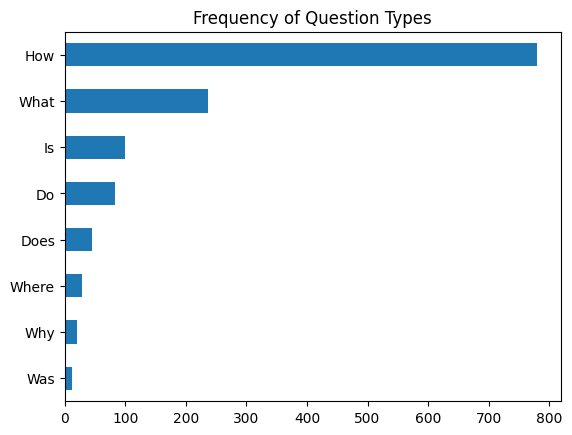

In [ ]:
import matplotlib.pyplot as plt
pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

##### Questions starting with How, What and Is cover more than 95% of the entire dataset

### Sample questions from these groups

In [ ]:
for q_type in ['How', 'What', 'Is']:
    for question in (dfs["train"][dfs["train"].question.str.startswith(q_type)].sample(n=3, random_state=42)["question"]):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


## Three problems that we will focus on here:
1. Framing the supervised learning problem
2. Tokenization and encoding of the text for QA tasks
3. Handling long passages that exceed the model's context limit

### Framing as Span classification task
Question for us is how to train a fresh or a pretrained model to generate relevant answers for a given question

It is possible or done by framing the QA as span classification task where the starting and the ending token from the answer are fed to the language model as labels. The architecture should look as shown in the image below.

##### In short, we want the model to predict where does the answer starts and ends in the context.

**bold text**![image.png](attachment:a92ed41a-5c8b-49e6-aad1-bb6ea92db6ce.png)

Image Source: https://learning.oreilly.com/library/view/natural-language-processing/9781098136789/ch07.html#qa-head

### Base Model
1. SubQA electronics dataset has only 1295 training samples.
2. We need to do transfer learning by taking an already trained model on QA tasks
3. Options are like MiniLM (Params=66M, F1=79.5), RoBerta-base(125M, 83.0), ALBERT-XXL(235M, 88.1), XLM-RoBERTa-large(570M, 83.8)
4. Better to test with **MiniLM** as it will be faster to train and it preserves 99% of the BERT's performance

##### NOTE the difference here is we take an already fine-tuned model on QA task than taking some model trained on an unsupervised task

### Tokenization
Use the AutoTokenize with MiniLM checkpoints

In [ ]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

#### Inputs in the form of (question, context) pairs

In [ ]:
question = "How much music can this hold?"
context = """An MP3 is about 1MB/minute, so about 6000 hours depending on the file size."""

inputs = tokenizer(question, context, return_tensors="pt")

In [ ]:
inputs

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 14905,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  1996,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]])}

token_type_ids indicate the part of the inputs that correspond ot the question (0s) and the answer(1s)

In [ ]:
tokenizer.decode(inputs["input_ids"][0])

'[CLS] how much music can this hold? [SEP] an mp3 is about 1mb / minute, so about 6000 hours depending on the file size. [SEP]'

#### Run a forward pass with the sample input_ids

In [ ]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)

print(outputs)

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-1.0619, -4.7759, -5.4051, -5.2591, -5.2996, -5.5154, -5.0100, -6.1931,
         -1.0619,  0.7555, -0.1241, -1.5151,  3.8058,  4.5635, -3.0061, -3.8606,
         -2.0051, -4.5976, -1.2444,  4.2204,  5.1371, -0.2043, -3.1518, -5.0111,
         -3.5610, -2.6119, -3.4716, -3.4210, -1.0619]]), end_logits=tensor([[-0.9882, -5.4957, -5.0272, -5.1663, -5.4640, -5.5374, -5.2239, -4.5714,
         -0.9882, -3.7424, -0.7967, -3.8335, -3.0339, -2.0091, -0.0790, -3.0468,
          4.3984,  0.4478, -3.1732, -3.1117,  0.7613,  5.7884, -0.0757, -4.7972,
         -3.7017, -3.0721,  0.1565,  2.0515, -0.9882]]), hidden_states=None, attentions=None)


The output by the QA model is of type **QuestionAnsweringModelOutput**

#### Get the final answer using argmax on start and end logits

In [ ]:
start_logits = outputs.start_logits
end_logits   = outputs.end_logits

In [ ]:
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 29])
Start logits shape: torch.Size([1, 29])
End logits shape: torch.Size([1, 29])


Shape is same as the inputs because every token is probable start and end logit

Only by applying the argmax, one can find the exact one

In [ ]:
start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1

In [ ]:
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)

In [ ]:
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


#### Repeating the above prediction using pipeline

In [ ]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)

pipe(question=question, context=context, topk=3)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/question_answering.py:323: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.34144559502601624,
  'start': 37,
  'end': 47,
  'answer': '6000 hours'},
 {'score': 0.19238954782485962,
  'start': 16,
  'end': 47,
  'answer': '1MB/minute, so about 6000 hours'},
 {'score': 0.13651761412620544,
  'start': 31,
  'end': 47,
  'answer': 'about 6000 hours'}]

#### Unavailable answers

In [ ]:
pipe(question="Why is there no data?", context=context,
     handle_impossible_answer=True)

{'score': 0.9189051985740662, 'start': 0, 'end': 0, 'answer': ''}

### Dealing with long passages
Using sliding window approach by setting **return_overflowing_tokens=True** in the tokenizer

#### Sample example to show how to deal with long passages

In [ ]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"],
                              return_overflowing_tokens=True, max_length=100, stride=25)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
len(tokenized_example.input_ids)

2

Earlier there was only one input ids but now, depending on the number of sliding windows

In [ ]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 88 tokens


##### Overlapping point

In [ ]:
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



### QA Pipeline using HayStack
1. Until now, the examples had question and context both given
2. In the real world, only question will be given and answer has to be found out from multiple existing reviews
3. Brute force way of sending all the reviews(entire context) will be very costly and slow as well
4. Solution is to use **retriever-reader** architecture

    - **Retriever(sparse or dense)** is responsible to perform the first level of filtering by using dot product between document(s) and query. In sparse retrievers, the document(s) is represented by the frequency of words while in dense retrievers, transformer based embeddings are used to represent both document and query and the dot product then prioritises semantic similarity.  
    
   - **Reader** is just like the model we have seen until now, called reading comprehension model

![image.png](attachment:27ecb6d9-1e6c-4b25-b7eb-add478621b1e.png)

Image Source: https://learning.oreilly.com/library/view/natural-language-processing/9781098136789/ch07.html#retriever-reader

### Use haystack to do the above
Two more components that make up the entire QA system with haystack:
1. Document Store - document oriented database,
   - ElasticSearchDocumentStore is compatible with both dense and sparse retrievers
3. Pipeline - combines all the components of a QA system

We will **initialise** the following below:


1.   Document Store using ESearch and Haystack
2.   Retriever
3.   Reader



We need to install the following:


1.   ElasticSearch (or other doc store)
2.   Haystack to connect these pieces to make entire QA system



## Now we set up ElasticSearch on google colab

## Download and setup the Elasticsearch instance

For demo purposes, the open-source(oss) version of the elasticsearch package was tried but was having problems in connection from haystack.

In [ ]:
# %%bash

# wget -q https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-oss-7.9.2-linux-x86_64.tar.gz
# wget -q https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-oss-7.9.2-linux-x86_64.tar.gz.sha512
# tar -xzf elasticsearch-oss-7.9.2-linux-x86_64.tar.gz
# sudo chown -R daemon:daemon elasticsearch-7.9.2/
# shasum -a 512 -c elasticsearch-oss-7.9.2-linux-x86_64.tar.gz.sha512
%%bash

wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.2-linux-x86_64.tar.gz -q
tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz
chown -R daemon:daemon elasticsearch-7.9.2

Run the instance as a daemon process

In [ ]:
%%bash --bg

sudo -H -u daemon elasticsearch-7.9.2/bin/elasticsearch

In [ ]:
# Sleep for few seconds to let the instance start.
import time
time.sleep(30)

Once the instance has been started, grep for `elasticsearch` in the processes list to confirm the availability.

In [ ]:
%%bash

ps -ef | grep elasticsearch

root        7314    7312  0 09:04 ?        00:00:00 sudo -H -u daemon elasticsearch-7.9.2/bin/elasticsearch
daemon      7315    7314 99 09:04 ?        00:00:29 /content/elasticsearch-7.9.2/jdk/bin/java -Xshare:auto -Des.networkaddress.cache.ttl=60 -Des.networkaddress.cache.negative.ttl=10 -XX:+AlwaysPreTouch -Xss1m -Djava.awt.headless=true -Dfile.encoding=UTF-8 -Djna.nosys=true -XX:-OmitStackTraceInFastThrow -XX:+ShowCodeDetailsInExceptionMessages -Dio.netty.noUnsafe=true -Dio.netty.noKeySetOptimization=true -Dio.netty.recycler.maxCapacityPerThread=0 -Dio.netty.allocator.numDirectArenas=0 -Dlog4j.shutdownHookEnabled=false -Dlog4j2.disable.jmx=true -Djava.locale.providers=SPI,COMPAT -Xms1g -Xmx1g -XX:+UseG1GC -XX:G1ReservePercent=25 -XX:InitiatingHeapOccupancyPercent=30 -Djava.io.tmpdir=/tmp/elasticsearch-670861460752951793 -XX:+HeapDumpOnOutOfMemoryError -XX:HeapDumpPath=data -XX:ErrorFile=logs/hs_err_pid%p.log -Xlog:gc*,gc+age=trace,safepoint:file=logs/gc.log:utctime,pid,tags:filecoun

query the base endpoint to retrieve information about the cluster.

Below methods were tried on Windows local machine but had some permission related issues while installing haystack.

In [ ]:
# Go to the url below to download and install the ElasticSearch server locally
url = "https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-8.9.0-windows-x86_64.zip"

NOTE down the version which is getting installed as it will be needed in the arguments while starting the server

#### Start the ElasticSearch server - only for local linux set up
1. Use Python's Popen() to spawn a new process and not let this notebook hang till the server is running

In [ ]:
# import os
# from subprocess import Popen, PIPE, STDOUT

##### Linux machines

In [ ]:
# Run Elasticsearch as a background process (LINUX Machines)


# !chown -R daemon:daemon elasticsearch-8.9.0
# es_server = Popen(args=['elasticsearch-8.9.0/bin/elasticsearch'],
#                   stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))


# Wait until Elasticsearch has started
# !sleep 30

##### Windows machines

1. Go the folder with elasticsearch-8.9.0/bin/
2. Go to config/elasticsearch.yml file
   - Either make security false after which we don't need user_id/passwd to access elastic search's REST apis
   - xpack.security.enabled: false
   - Or make security true which will need the user id and password(should be visible in the console logs) to access the REST apis
4. Run the elasticsearch.bat file

default port = 9200

In [ ]:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "958b738cdd53",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "VQDeMWYzTx2_T0iTTcuCUw",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


##### The above REST api call shows the server is up and running

#### Instantiate the Document store

In [ ]:
%%capture
%%bash

pip install --upgrade pip
pip install farm-haystack[colab,elasticsearch,metrics]
#,metrics,inference]

# Install pygraphviz for visualization of Pipelines
# apt install libgraphviz-dev
# pip install pygraphviz
# SOURCE - https://colab.research.google.com/github/deepset-ai/haystack-tutorials/blob/main/tutorials/15_TableQA.ipynb#scrollTo=zY3s8O7Q-fhG

In [ ]:
import os

# Get the host where Elasticsearch is running, default to localhost
host = os.environ.get("ELASTICSEARCH_HOST", "localhost")
print(host)

localhost


In [ ]:
from haystack.document_stores import ElasticsearchDocumentStore
document_store = ElasticsearchDocumentStore(return_embedding=True)

# document_index = "document"
# document_store = ElasticsearchDocumentStore(host=host, index=document_index)

ElasticsearchDocumentStore creates two indices on Elasticsearch


1.   Document index for storing documents
2.   label - for storing the annotated answer spans


subjQA reviews are inserted into the document index

Haystack document stores expect a list of dictionaries with **text** and **meta**

In older versions, it was **text**, but now it is **content** as done in below cell

### Write the subjQA reviews into the document index

In [ ]:
for split, df in dfs.items():
  docs = [{"content":row["context"],
           "meta": {"item_id": row["title"],
                    "question_id": row["id"],
                    "split": split}} for _, row in df.drop_duplicates(subset="context").iterrows()]
  # print(docs)
  document_store.write_documents(documents=docs, index="document")

print(f"Loaded {document_store.get_document_count()} documents")

Loaded 1615 documents


### Initialise the  Retriever
For Sparse retrievers, we will use


*   BM25, improved version of TF-IDF, represents the question and context as sparse vectors. Used as default by ElasticsearchRetriever in haystack. We will use BM25Retriever class in the latest version of haystack
*   



In [ ]:
from haystack.nodes import BM25Retriever

In [ ]:
bm_retriever = BM25Retriever(document_store=document_store)

##### Sample Query

In [ ]:
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = bm_retriever.retrieve(
    query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})

In [ ]:
retrieved_docs

[<Document: {'content': 'This is a gift to myself.  I have been a kindle user for 4 years and this is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my laptop, my phone and my iPod classic.  I love my iPod but watching movies on the plane with it can be challenging because it is so small. Laptops battery life is not as good as the Kindle.  So the Fire combines for me what I needed all three to do. So far so good.', 'content_type': 'text', 'score': 0.6857824513476455, 'meta': {'item_id': 'B0074BW614', 'question_id': '868e311275e26dbafe5af70774a300f3', 'split': 'train'}, 'id_hash_keys': ['content'], 'embedding': None, 'id': '252e83e25d52df7311d597dc89eef9f6'}>,
 <Document: {'content': 'Plays Netflix great, WiFi capability has great range. Resolution on the screen is AMAZING! For the price you cannot go wrong. Bought one for my spouse and myself after becoming addicted to hers! Our son LOVES it a

# Initialise a Reader


1.   FarmReader
2.   TransformersReader



In [ ]:
from haystack.nodes import FARMReader

In [ ]:
model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride,
                    return_no_answer=True)

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
question, context

('How much music can this hold?',
 'An MP3 is about 1MB/minute, so about 6000 hours depending on the file size.')

In [ ]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

{'query': 'How much music can this hold?', 'no_ans_gap': 12.975613594055176, 'answers': [<Answer {'answer': '6000 hours', 'type': 'extractive', 'score': 0.6045688986778259, 'context': 'An MP3 is about 1MB/minute, so about 6000 hours depending on the file size.', 'offsets_in_document': [{'start': 37, 'end': 47}], 'offsets_in_context': [{'start': 37, 'end': 47}], 'document_ids': ['9f2a322cabcdb208246a2a768c80a3f4'], 'meta': {}}>]}


#### Combine everything using haystack pipelines

In [ ]:
from haystack.pipelines import ExtractiveQAPipeline

In [ ]:
pipe = ExtractiveQAPipeline(reader, bm_retriever)

In [ ]:
n_ans = 3
preds = pipe.run(query=query,params={"Retriever": {"top_k": 3},
                                     "Reader": {"top_k": n_ans},
                                     "filters":{"item_id":[item_id],
                                                "split":["train"]}
                                     }
                 )

In [ ]:
print(f"Question: {preds['query']}")
for idx in range(n_ans):
    print(f"Answer {idx+1}: {preds['answers'][idx].answer}")
    print(f"Review snippet: ...{preds['answers'][idx].context}...")
    print("\n\n")

Question: Is it good for reading?
Answer 1: it is great for reading books when no light is available
Review snippet: ...ecoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest good headphones t...



Answer 2: I mainly use it for book reading
Review snippet: ... is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my la...



Answer 3: 
Review snippet: ...None...





Performance of such a system depends on both Retriever and the Reader.

However, if Retriever doesn't get the relevant documents, it doesn't matter how good is the Reader!

# Evaluate the Retriever

Here we focus on the Retriever's evaluation metrics

The priority is for the recall as we want as many documents that contains the answer to be in the retrieved list. Or at least the document with the correct answer should always be there in the retrieved list.

*Recall  measures the fraction of all relevant documents that are retrieved. In this context, “relevant” simply means whether the answer is present in a passage of text or not, so given a set of questions, we can compute recall by counting the number of times an answer appears in the top k documents returned by the retriever.*

NOTE: compleimentary to recall for the retriever's metric, meanAveragePrecision  

Two ways to evaluate retrievers in haystack:


1.   In built eval() function - not useful here as each doc is for a particular product_id, so we need to do it separately for each product_id and then combine across the product_ids  
2.   custom metric function to be used in the pipeline



In [ ]:
from haystack import Label, Document, Answer

In [ ]:
from haystack.pipelines import Pipeline
# from haystack.schema import EvalDocuments

class EvalRetrieverPipeline:
  def __init__(self, retriever):
    self.retriever = retriever
    # self.eval_retriever = EvalDocuments()
    pipe = Pipeline()
    pipe.add_node(component=self.retriever, name="ESRetriever", inputs=["Query"])
    # pipe.add_node(component=self.eval_retriever, name="evalRetriever", inputs=["ESRetriever"])
    self.pipeline = pipe


pipe = EvalRetrieverPipeline(bm_retriever)

In [ ]:
for i, row in dfs["test"].iterrows():
  print(row)
  print(type(row["answers.text"][0]))
  break

domain                                                             electronics
nn_mod                                                              comparable
nn_asp                                                                 quality
query_mod                                                              perfect
query_asp                                                              balance
q_reviews_id                                  aa99f9b7fe9fe9c921bc2f963cb22121
question_subj_level                                                          1
ques_subj_score                                                            0.0
is_ques_subjective                                                       False
review_id                                     f011c75fb8d26066217e64b3ff470d84
id                                            d0781d13200014aa25860e44da9d5ea7
title                                                               B00001WRSJ
context                      I have been a headphone

In [ ]:
labels = []
for i, row in dfs["test"].iterrows():
    # Metadata used for filtering in the Retriever
    meta = {"item_id": row["title"], "question_id": row["id"]}
    # Populate labels for questions with answers
    if len(row["answers.text"]):
        for answer in row["answers.text"]:
          label = Label(query=row["question"],
                        document=Document(content=row["context"],
                                          meta=meta),
                        answer=Answer(answer=answer),
                        origin="gold-label",
                        meta=meta,
                        is_correct_answer=True,
                        is_correct_document=True,
                        no_answer=False)
          labels.append(label)
    # Populate labels for questions without answers
    else:
        label = Label(
            query=row["question"],
            document=Document(content=row["context"],
                              meta=meta),
            answer=Answer(""), origin="gold-label",
            meta=meta, is_correct_answer=True, is_correct_document=True,
            no_answer=True)
        labels.append(label)

In [ ]:
print(labels[0])

<Label: {'id': '813b1f38-6ba8-426d-9c8d-77959bb17832', 'query': 'What is the tonal balance of these headphones?', 'document': {'id': 'a73f54ddc5b1fcc7f4fbf04bd564a278', 'content': "I have been a headphone fanatic for thirty years and have owned and used a variety of headphones over those years, to include Stax SR-5, Sennheiser HD-424 and HD-580.  The Sony MDRV6 excells as the best value of any headphone that I've ever owned.  They are especially good at producing natural-sounding deep bass, and the overall octave-to-octave balance is excellent.  The sound quality is all in all comparable to other headphones that cost considerably more.The MDRV6 is especially well-suited for travel due to the collapsible design, and for noisy environments or for quiet environments such as a library where the sound emitted by open-back headphones would distract others.The MDRV6 is not quite as comfortable as some other headphones, but the comfort can be improved enormously by replacing the pads with the 

In [ ]:
print(labels[0].id, labels[13].id, labels[14].id, labels[15].id)

51ac90d4-238a-42e4-8a73-52e8a1e2cfcd 7f4f7c32-0a3b-49df-8287-cdd91e1b29c4 dee76bb7-6534-4a34-837c-cb793fe4dba3 bff07fa4-7b95-4cef-bf41-bd3b81b4d685


Write Labels to LabelIndex

In [ ]:
document_store.write_labels(labels, index="label")

In [ ]:
print(f"""Loaded {document_store.get_label_count(index="label")} \
question-answer pairs""")

Loaded 910 question-answer pairs


If the id was choosen as *i*, it would lead to less pairs, precisely 358 but we choose uuid as the id and hence more pairs

BUT eventually, for a unique item id, we have 330 pairs only

Aggregated Labels

In [ ]:
labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"]
)


In [ ]:
print(len(labels_agg))

330


All the answers associated with a question are aggregated together in a multiple answers field as shown below

In [ ]:
print(labels_agg[109])

<MultiLabel: {'labels': [{'id': 'd42185fe-e9b7-4871-83c9-f204d1115706', 'query': 'How does the fan work?', 'document': {'id': '60a9992eb862b0a90ed516c52125b7e0', 'content': 'the usb on the back caused my mac to restart when i would plug something into about 50% of the time.  very annoying but the fan is really really good!', 'content_type': 'text', 'meta': {'item_id': 'B002MU1ZRS', 'question_id': '5a9b7616541f700f103d21f8ad41bc4b'}, 'id_hash_keys': ['content'], 'score': None, 'embedding': None}, 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'gold-label', 'answer': {'answer': 'the fan is really really good', 'type': 'extractive', 'score': None, 'context': None, 'offsets_in_document': None, 'offsets_in_context': None, 'document_ids': None, 'meta': {}}, 'pipeline_id': None, 'created_at': '2023-08-31 06:29:15', 'updated_at': '2023-08-31 06:29:15', 'meta': {'item_id': 'B002MU1ZRS', 'question_id': '5a9b7616541f700f103d21f8ad41bc4b'}, 'filters': {'item_id': ['B002MU1ZRS']}

In [ ]:
print(labels_agg[109].query, labels_agg[109].answers)

How does the fan work? ['the fan is really really good', 'this cooler fits it just about perfectly', "the fan itself isn't super loud. There is an adjustable dial to change fan speed"]


In [ ]:
i = 0
for l in labels_agg:
  print(l.labels)
  break


[<Label: {'id': '34b8662a-4888-4904-9798-31793725008d', 'query': 'What is the tonal balance of these headphones?', 'document': {'id': 'a73f54ddc5b1fcc7f4fbf04bd564a278', 'content': "I have been a headphone fanatic for thirty years and have owned and used a variety of headphones over those years, to include Stax SR-5, Sennheiser HD-424 and HD-580.  The Sony MDRV6 excells as the best value of any headphone that I've ever owned.  They are especially good at producing natural-sounding deep bass, and the overall octave-to-octave balance is excellent.  The sound quality is all in all comparable to other headphones that cost considerably more.The MDRV6 is especially well-suited for travel due to the collapsible design, and for noisy environments or for quiet environments such as a library where the sound emitted by open-back headphones would distract others.The MDRV6 is not quite as comfortable as some other headphones, but the comfort can be improved enormously by replacing the pads with the

In [ ]:
def run_pipeline(pipeline, top_k_retriever=10, top_k_reader=4):
    for l in labels_agg:
        _ = pipeline.pipeline.run(
                                  query=query,
                                  labels=l.labels,
                                  params={"ESRetriever": {"top_k": top_k_retriever},
                                     "filters":{"item_id":[l.labels[0].meta["item_id"]],
                                                "split":["test"]}
                                     }
                 )

In [ ]:
run_pipeline(pipe, top_k_retriever=3)


In [ ]:
# pipe.retriever.eval(label_index="label", doc_index="document", top_k=3)

Evaluation metrics for entire data set

In [ ]:
# !pip install farm-haystack[metrics]

In [ ]:
eval_result = pipe.pipeline.eval(labels=labels_agg, params={"ESRetriever":{"top_k":3}})

In [ ]:
eval_result["ESRetriever"].shape

(812, 25)

In [ ]:
metrics = eval_result.calculate_metrics()

In [ ]:
metrics

{'ESRetriever': {'recall_multi_hit': 0.8957070707070707,
  'recall_single_hit': 0.9,
  'precision': 0.744949494949495,
  'map': 0.8353535353535353,
  'mrr': 0.8378787878787879,
  'ndcg': 0.8517243549531958}}

In [ ]:
metrics["ESRetriever"]["recall_multi_hit"] , metrics["ESRetriever"]["recall_single_hit"]



(0.8957070707070707, 0.9)

In [ ]:
print(f"Recall@3: {metrics['ESRetriever']['recall_multi_hit']:.2f}")

Recall@3: 0.90


Evluation metric for test set only

In [ ]:
t_eval_result = pipe.pipeline.eval(labels=labels_agg, params={"ESRetriever":{"top_k":3},
                                                                 "filters":{"split":["train"]}
                                              }
                   )
print(t_eval_result["ESRetriever"].shape)

(663, 25)


In [ ]:
v_eval_result = pipe.pipeline.eval(labels=labels_agg, params={"ESRetriever":{"top_k":3},
                                                                 "filters":{"split":["val"]}
                                              }
                   )
print(v_eval_result["ESRetriever"].shape)

(330, 25)


In [ ]:
test_eval_result = pipe.pipeline.eval(labels=labels_agg, params={"ESRetriever":{"top_k":3},
                                                                 "filters":{"split":["test"]}
                                              }
                   )
print(test_eval_result["ESRetriever"].shape)
test_metrics = test_eval_result.calculate_metrics()
print(f"Recall@3: {test_metrics['ESRetriever']['recall_multi_hit']:.2f}")
test_metrics


(644, 25)
Recall@3: 0.95


{'ESRetriever': {'recall_multi_hit': 0.9547979797979798,
  'recall_single_hit': 0.9575757575757575,
  'precision': 0.8343434343434345,
  'map': 0.9212962962962965,
  'mrr': 0.9227272727272727,
  'ndcg': 0.9303831604655081}}

### Choose the right value of k

In [ ]:
def evaluate_retriever(retriever, topk_values = [1,3,5,10,20]):
    topk_results = {}

    for topk in topk_values:
        # Create Pipeline
        p = EvalRetrieverPipeline(retriever)
        # Loop over each question-answers pair in test set
        run_pipeline(p, top_k_retriever=topk)
        # Get metrics
        # topk_results[topk] = {"recall": p.eval_retriever.recall}
        p_eval_result = p.pipeline.eval(labels=labels_agg, params={"ESRetriever":{"top_k":topk},
                                                                 "filters":{"split":["test"]}
                                              }
                   )
        metrics = p_eval_result.calculate_metrics()
        topk_results[topk] = metrics['ESRetriever']['recall_multi_hit']

    return pd.DataFrame.from_dict(topk_results, orient="index", columns=["recall"])


es_topk_df = evaluate_retriever(bm_retriever)

In [ ]:
# es_topk_df = es_topk_df.rename(columns={0:"recall"})

In [ ]:
es_topk_df

,recall
1,0.886364
3,0.954798
5,0.981818
10,0.993939
20,0.993939


In [ ]:
def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y="recall", ax=ax, label=retriever_name)
    plt.xticks(df.index)
    plt.ylabel("Top-k Recall")
    plt.xlabel("k")
    plt.show()

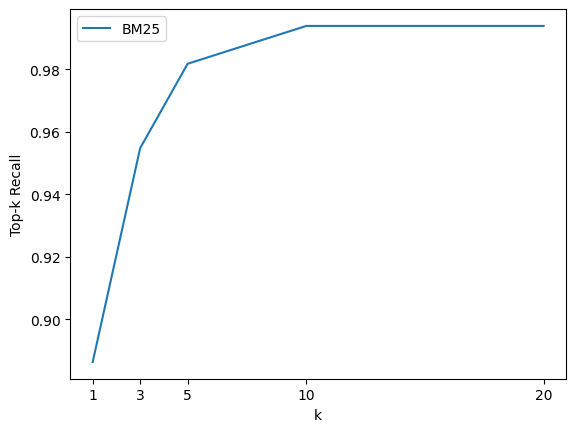

In [ ]:
plot_retriever_eval([es_topk_df], ["BM25"])

Inflection point occurs at k=5 while k=10 can offer an excellent choice for the recall!

Until we *retrieved* documents using sparse technique with BM25 retriever.

Now we will retrieve using dense vector representation.

The idea is to reduce the value of k for which we get the same recall performance.

## Dense Passage Retrieval

In [ ]:
from haystack.nodes import DensePassageRetriever

In [ ]:
dpr_retriever = DensePassageRetriever(document_store=document_store,
                                      query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
                                      passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
                                      embed_title=False)

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Update the encoding for each document in the document index

In [ ]:
document_store.update_embeddings(retriever=dpr_retriever)

Create embeddings: 100%|██████████| 1616/1616 [00:22<00:00, 68.43 Docs/s]
Updating embeddings: 10000 Docs [00:49, 203.04 Docs/s]


In [ ]:
dpr_topk_df = evaluate_retriever(dpr_retriever)

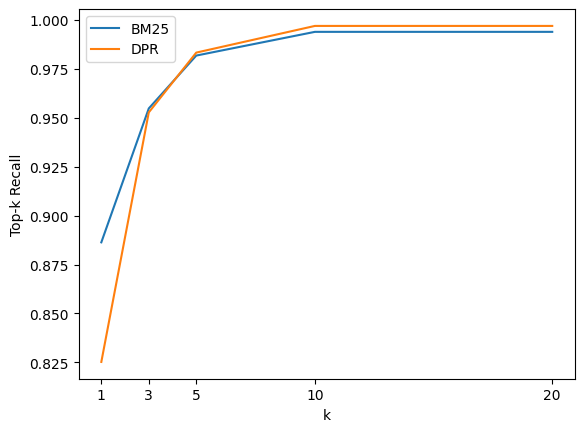

In [ ]:
plot_retriever_eval([es_topk_df, dpr_topk_df], ["BM25", "DPR"])

There is not much change in the right value of k even with dense retriever using dense embeddings.

One can use a different document store like FAISS for a faster similarity search. One can also fine-tune on a target domain  

# Evaluating the QA System


In [ ]:
# Initialize retriever pipeline
pipe = EvalRetrieverPipeline(bm_retriever)
# Add nodes for reader
pipe.pipeline.add_node(component=reader, name="QAReader",
              inputs=["ESRetriever"])
# Evaluate!
run_pipeline(pipe)
# Extract metrics from reader
eval_result = pipe.pipeline.eval(labels=labels_agg, params={"filters": {}})
qa_system_metrics = eval_result.calculate_metrics()
qa_system_metrics


{'ESRetriever': {'recall_multi_hit': 0.9636363636363636,
  'recall_single_hit': 0.9636363636363636,
  'precision': 0.7277873977873978,
  'map': 0.8500096200096199,
  'mrr': 0.8491991341991342,
  'ndcg': 0.8781763833928322},
 'QAReader': {'exact_match': 0.5696969696969697,
  'f1': 0.6954639493790712,
  'num_examples_for_eval': 330.0}}

## Evaluating only the reader

Some errors that needs to be resolved as per the latest version of haystack and FARMReader

In [ ]:
# from haystack.eval import EvalAnswers

def evaluate_reader(reader):
    score_keys = ['top_1_em', 'top_1_f1']
    # eval_reader = EvalAnswers(skip_incorrect_retrieval=False)
    pipe = Pipeline()
    pipe.add_node(component=reader, name="QAReader", inputs=["Query"])
    # pipe.add_node(component=eval_reader, name="EvalReader", inputs=["QAReader"])
    for l in labels_agg:
      # print(l)
      doc = document_store.query(l.query,
                                 filters={"question_id":[l.labels[0].meta["question_id"]]})
      # print(l.query, len(doc))
      # documents=doc, labels=l
      _ = pipe.run(query=l.query,
                   labels=l.labels,
                   params={"QAReader": {"documents": doc},
                           "filters":{"item_id":[l.labels[0].meta["item_id"]],
                                      "split":["test"]}
                           }
                   )


    print("Finished for loop")
    print(l.query, len(doc), doc)
    eval_result = pipe.eval(labels=labels_agg, params={"filters": {}})
    print(eval_result)
    return {}
    # return {k:v for k,v in eval_reader.__dict__.items() if k in score_keys}

reader_eval = {}
reader_eval["Fine-tune on SQuAD"] = evaluate_reader(reader)

Finished for loop
Is the cord safe to grab the transformer? 1 [<Document: {'content': "After being disappointed by a $50 pair of Sony headphones, I snagged these Audio-Technica's based on the reviews here on Amazon. I'm very impressed with the quality of these headphones. The cord is very long and durable, the jack is strong and well constructed. The headphones themselves are very comfortable, block out a ton of background noise, and aren't too bulky or heavy. They're very durable and can take a beating.The sound quality for a non-amplified pair of headphones is nothing short of amazing. The majority of headphones in this price range are boomy, obnoxious headphones with poor midrange and high end performance. The ATH-M30 is incredibly well balanced with heavy lows, comfortable mids, and stunningly clear highs. I can't recommend a better pair of headphones in this price range.", 'content_type': 'text', 'score': 0.6270838983358263, 'meta': {'item_id': 'B00007E7C8', 'question_id': '31dafa

ValueError: ignored

Sample Label entry

In [ ]:
# <MultiLabel: {'labels': [{'id': '34b8662a-4888-4904-9798-31793725008d',
#                           'query': 'What is the tonal balance of these headphones?',
#                           'document': {'id': 'a73f54ddc5b1fcc7f4fbf04bd564a278',
#                                        'content': "I have been a headphone fanatic for thirty years and have owned and used a variety of headphones over those years, to include Stax SR-5, \
#                                         Sennheiser HD-424 and HD-580.  The Sony MDRV6 excells as the best value of any headphone that I've ever owned.  They are especially good at producing \
#                                         natural-sounding deep bass, and the overall octave-to-octave balance is excellent.  The sound quality is all in all comparable to other headphones \
#                                         that cost considerably more.The MDRV6 is especially well-suited for travel due to the collapsible design, and for noisy environments or for quiet \
#                                         environments such as a library where the sound emitted by open-back headphones would distract others.The MDRV6 is not quite as comfortable as some \
#                                         other headphones, but the comfort can be improved enormously by replacing the pads with the velour pads from BeyerDynamic.  The pads that come on \
#                                         the MDRV6 have a non-breathable cover, and significant additional discomfort is caused by the way that the thin foam cover is glued to the pad \
#                                         around the inner circumference of the pad, which prevents the top and back of your ear from slipping into the space between the pad and the face \
#                                         of the headphone.  This forces the pad to rest on the back of the ear, which compresses the ear and eventually becomes uncomfortable.  I read \
#                                         on a web forum where several people had replaced the pads (which eventually come apart) with a velour pad made by BeyerDynamic, and after I did \
#                                         this replacement on my one pair that had a damaged pad, the increase in comfort was so great that I immediately did the other pair.  The thin \
#                                         cover can be glued down to the headphone face if needed to hold it in place, which then allows the top and rear of your ear to naturally \
#                                         slide under the inner circumference of the pad, which is considerably more comfortable.  I can recommend this trivial modification without \
#                                         reservation to anyone who owns these headphones.  Even if you don't replace the pads with the BeyerDynamic velour pads, I suggest removing \
#                                         the pads anyway, then carefully separating the thin cover from the pad, and glueing the cover directly to the headphone surface.",
#                                       'content_type': 'text',
#                                        'meta': {'item_id': 'B00001WRSJ', 'question_id': 'd0781d13200014aa25860e44da9d5ea7'},
#                                        'id_hash_keys': ['content'], 'score': None, 'embedding': None
#                                        },
#                           'is_correct_answer': True,
#                           'is_correct_document': True,
#                           'origin': 'gold-label',
#                           'answer': {'answer': 'I have been a headphone fanatic for thirty years',
#                                      'type': 'extractive', 'score': None, 'context': None,
#                                      'offsets_in_document': None, 'offsets_in_context': None,
#                                      'document_ids': None, 'meta': {}
#                                      },
#                           'pipeline_id': None,
#                           'created_at': '2023-08-31 06:29:15',
#                           'updated_at': '2023-08-31 06:29:15',
#                           'meta': {'item_id': 'B00001WRSJ', 'question_id': 'd0781d13200014aa25860e44da9d5ea7'},
#                           'filters': {'item_id': ['B00001WRSJ']}
#                           }
#                          ],
#               'query': 'What is the tonal balance of these headphones?',
#               'filters': {'item_id': ['B00001WRSJ']},
#               'id': '1f380c5429a27445d5771686af8b73a3',
#               'no_answer': False,
#               'answers': ['I have been a headphone fanatic for thirty years'],
#               'offsets_in_documents': [], 'offsets_in_contexts': [],
#               'document_ids': ['a73f54ddc5b1fcc7f4fbf04bd564a278'],
#               'contexts': ["I have been a headphone fanatic for thirty years and have owned and used a variety of headphones over those years, to include Stax SR-5, Sennheiser HD-424\
#                and HD-580.  The Sony MDRV6 excells as the best value of any headphone that I've ever owned.  They are especially good at producing natural-sounding deep bass, and the \
#                overall octave-to-octave balance is excellent.  The sound quality is all in all comparable to other headphones that cost considerably more.The MDRV6 is especially \
#                well-suited for travel due to the collapsible design, and for noisy environments or for quiet environments such as a library where the sound emitted by open-back \
#                headphones would distract others.The MDRV6 is not quite as comfortable as some other headphones, but the comfort can be improved enormously by replacing the pads \
#                with the velour pads from BeyerDynamic.  The pads that come on the MDRV6 have a non-breathable cover, and significant additional discomfort is caused by the way that \
#                the thin foam cover is glued to the pad around the inner circumference of the pad, which prevents the top and back of your ear from slipping into the space between the \
#                pad and the face of the headphone.  This forces the pad to rest on the back of the ear, which compresses the ear and eventually becomes uncomfortable.  I read on a web \
#                forum where several people had replaced the pads (which eventually come apart) with a velour pad made by BeyerDynamic, and after I did this replacement on my one pair \
#                that had a damaged pad, the increase in comfort was so great that I immediately did the other pair.  The thin cover can be glued down to the headphone face if needed to \
#                hold it in place, which then allows the top and rear of your ear to naturally  slide under the inner circumference of the pad, which is considerably more comfortable.  \
#                I can recommend this trivial modification without reservation to anyone who owns these headphones.  Even if you don't replace the pads with the BeyerDynamic velour pads, \
#                I suggest removing the pads anyway, then carefully separating the thin cover from the pad, and glueing the cover directly to the headphone surface."
#                ]
#               }>